# Yapay Sinir Ağları

![](resim/network.png)



## İleri Besleme

- $ Z(t) = W(t)A(t-1) + b(t)  $
- $ A(t) = \sigma(Z(t))  $

$$
Z(t) = 
\begin{bmatrix}
. \\
z_2(t) \\
. \\
. \\
\end{bmatrix}
=
\begin{bmatrix}
.       & . & . \\
 w_{i1}(t)       & w_{i2}(t)  & w_{i3}(t)  \\
.       & . & . \\
.       & . & . \\
\end{bmatrix}
\begin{bmatrix}
a_1(t-1) \\
a_2(t-1)\\
a_3(t-1)\\
\end{bmatrix}
+
\begin{bmatrix}
. \\
b_2(t) \\
. \\
. \\
\end{bmatrix}
$$

#### Yardımcı Türevler
$$
\frac{dz_i(t)}{ dw_{ij}(t)} = a_j(t-1)
\;\;\;\text{   ve   }\;\;\;
\frac{dz_i(t)}{db_{i}(t)} = 1
$$
ayrıca

$$
\frac{dz_i(t)}{dz_j(t-1)} = 
\frac{dz_i(t)}{da_j(t-1)} \frac{da_j(t-1)}{dz_j(t-1)} =  
w_{ij}(t) \sigma'(z_j(t-1)) 
$$


## Geri Besleme
#### Odak

$$
\triangle_i(t) =
\frac{dH}{ dz_{i}(t)} 
$$
#### Aranılan Türevler
$$
\frac{dH}{ dw_{ij}(t)} = 
\frac{dH}{ dz_i(t)}
\frac{dz_i(t)}{ dw_{ij}(t)} =
\triangle_i(t) a_j(t-1)
$$
ve 
$$
\frac{dH}{ db_{i}(t)} 
=\frac{dH}{ dz_i(t)}
\frac{dz_i(t)}{ db_{i}(t)} 
= \triangle_i(t)
$$

#### Geri yayılım

![](resim/geriyayilim.png)

$t.$ katmandaki bütün $\triangle_i(t)$ biliniyorsa, bir önceki katmandaki $\triangle_j(t-1)$ nasıl hesaplanır?


$$
\triangle_j(t-1) =
\frac{dH}{ dz_{j}(t-1)} 
= \sum_i \frac{dH}{ dz_{i}(t)} \frac{dz_i(t)}{dz_j(t-1)}
= \sum_i \triangle_i(t) w_{ij}(t) \sigma'(z_j(t-1)) 
$$

Dolayısıyla
$$
\triangle(t-1) 
= W^T(t) \triangle(t)  * \sigma'(z_j(t-1)) 
$$

# Geri yayılım Algoritması
#### Gradyan iniş
![](resim/gradyan.png)
### Hata
$$
H = \frac{1}{2n} \sum^n_{i=1} (y_i - a_i(T))^2
$$

### Hatanın son katmana göre türevi
$$
\triangle(T) =  \frac{dH}{ dz(T)} = \frac{dH}{ da(T)} \frac{da(T)}{ dz(T)}
= (a(T) - y) * \sigma'(z(T))
$$

### Hatanın geri yayılımı
$$
\triangle(t-1) 
= W^T(t) \triangle(t)  * \sigma'(z_j(t-1)) 
$$

### En iyi parametreleri bulmak
$$
\frac{dH}{ dw_{ij}(t)} = 
\triangle_i(t) a_j(t-1)
$$
ve 
$$
\frac{dH}{ db_{i}(t)} 
= \triangle_i(t)
$$


# Görüntülerde duygu tanıma
Burada öğrendiklerimizi ve yazdfığımız YSA kodunu şu veri seti üzerinde deneyebilirsiniz.

https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge


In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import timeit
import random

In [2]:
class yapay_sinir_agi():
    def __init__(self, katmanlar):
        self.katmanlar = katmanlar
        self.b = [np.random.randn(k, 1) for k in self.katmanlar[1:]] # bias degerleri (ilk katman haric)
        self.W = [np.random.randn(k2, k1) for k1, k2 in zip(self.katmanlar[:-1],self.katmanlar[1:])]
        self.H = [] # hata
        
        self.onlyOnce = True

    def ag(self):
        return self.W, self.b
    
    def ileribesleme(self, a):
        """Katman katman yeni a degerleri hesaplaniyor"""
        a = self.checkDimension(a)
        for w, b in zip(self.W, self.b):
            z = np.dot(w, a)+b
            a = self.sigmoid(z)
        return a
    
    def geribesleme(self,X,y):
        delta_b = [np.zeros(b.shape) for b in self.b]
        delta_w = [np.zeros(w.shape) for w in self.W]
        a = X; A, Z = [a], []  # A, Z degerleri
        for w, b in zip(self.W, self.b):# z ve a degerlerini depolayalim
            z = np.dot(w, a) + b
            a = self.sigmoid(z)
            Z.append(z); A.append(a)
            
            self.printShape(b, "b", w, "w")


        
        hata = A[-1] - y # En son katmandaki hata 
        delta = hata * self.sigmoid_turevi(Z[-1])
        delta_b[-1] = delta # Son katmanda W, b'deki degisim  
        delta_w[-1] = delta * A[-2].T # ERROR: np.dot(delta, A[-2].T)
        
        self.printShape(delta_b[-1], "delta_b[-1]", delta_w[-1], "delta_w[-1]")
        
        for k in range(2, len(self.katmanlar)): # Hatanin geriye yayilimi
            delta = np.dot(self.W[-k+1].T, delta) * self.sigmoid_turevi(Z[-k])
            delta_b[-k] = delta
            delta_w[-k] = delta * A[-k-1].T # ERROR: np.dot(delta, A[-k-1].T)
            
            self.printShape(delta_b[-k], "delta_b[-k]", delta_w[-k], "delta_w[-k]")
        self.onlyOnce = False

        return (delta_b, delta_w)  
    
    def hata(self,X,y):
        a = self.ileribesleme(X)
        if a.shape != y.shape: print(hata)
        return np.sum(np.power(a-y,2))
    
    
    def gradyan_inis(self, X_train, y_train, alpha, number_steps):
        print("X_train.shape",X_train.shape)
        print("y_train.shape",y_train.shape)
        for s in range(number_steps):
            i, m = 0,X_train.shape[1]
            X, y = X_train[:,[i]], y_train[:,[i]]
            tum_delta_b, tum_delta_w = self.geribesleme(X,y)
            hata = self.hata(X,y)
            
            for i in range(1,m): # Tum X kolonlari icin
                X, y = X_train[:,[i]], y_train[:,[i]]
                delta_b, delta_w = self.geribesleme(X,y)
                tum_delta_b = [tdb + db for tdb, db in zip(tum_delta_b, delta_b)]
                tum_delta_w = [tdw + dw for tdw, dw in zip(tum_delta_w, delta_w)]
                hata += self.hata(X,y)
                    
            tum_delta_b = [alpha*tdb for tdb in tum_delta_b]
            tum_delta_w = [alpha*tdw for tdw in tum_delta_w]
        
            self.W = [w - dw for w, dw in zip(self.W, tum_delta_w)]
            self.b = [b - db for b, db in zip(self.b, tum_delta_b)]
            self.H.append(hata/m)

    def fit(self, X_train, y_train, alpha = 0.0000001, number_steps = 1000):  
        X_train = X_train.T # X verileri kolon=gozlem, satir=oznitelik (alistigimizin tersi)
        y_train = self.checkOutputLayer(y_train)
        return self.gradyan_inis(X_train, y_train, alpha, number_steps)
    
    def predict(self, X_test):
        if self.katmanlar[-1] == 1 : 
            tahmin = self.ileribesleme(X_test.T) >= 0.5  
            t = tahmin.astype('int')
            return t[0]
        return np.argmax(self.ileribesleme(X_test.T), axis= 0)
    
    #### Yardimci Fonksiyonlar
    def sigmoid(self,z):
        return 1.0/(1.0+np.exp(-z))
    def sigmoid_turevi(self,z):
        return self.sigmoid(z)*(1-self.sigmoid(z))
    def checkDimension(self,x):
        if x.ndim == 1: return x.reshape(x.shape[0], 1)
        return x
    def checkOutputLayer(self, y):
        if len(set(y)) == 2: return y.reshape(1,y.shape[0])
        y_vec = np.zeros((len(set(y)),len(y)))
        for c,r in enumerate(y):  y_vec[r,c] = 1
        return y_vec
    def printShape(self, b, bs, w, ws):
        if self.onlyOnce == True: print(bs, ".shape: ",b.shape," ", ws ,".shape: ",w.shape)

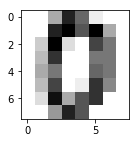

Etiket: 0


In [3]:
#Rakamlar veri kümesini yüklüyoruz.
from sklearn.datasets import load_digits
#Veri kümesini etiket değerleriyle birlikte yükleyelim.
X,y = load_digits(return_X_y=True)

rakam1 = X[0]
rakam1 = np.reshape(rakam1, (8,8))

plt.figure(figsize= (2,2))
plt.imshow(rakam1, cmap="gray_r")
plt.show()
etiket1 = y[0]
print('Etiket: ' + str(etiket1))

In [4]:
def loadRdigits(r = 2):
    
    #Rakamlar veri kümesini yüklüyoruz.
    from sklearn.datasets import load_digits
    #Veri kümesini etiket değerleriyle birlikte yükleyelim.
    DX,Dy = load_digits(return_X_y=True)

    # Bu veri kumesinden sadece 0, 1 ..r  rakamlarini secelim
    X= DX[Dy < r]
    y= Dy[Dy < r]

    #################################################
    # Datayi train ve test olark ayir
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    print("ogrenme kumesinin uzunlugu: ", len(X_train))
    print("test kumesinin uzunlugu: ", len(X_test))

    #################################################
    # Datayi normalize et 
    #.      Standardize features by removing the mean and scaling to unit variance
    #.      Centering and scaling happen independently on each feature
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()

    # Fit only to the training data
    scaler.fit(X_train)

    # Now apply the transformations to the data:
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

In [5]:
def runNN(r, alpha = 0.001, number_steps = 100):
    if r == 2: r = 1
    # Fitting Our Own Neural Network to the Training set
    start_time = timeit.default_timer()
    ysa = yapay_sinir_agi(katmanlar = [64,12,r])
    ysa.fit(X_train_scaled,y_train, alpha, number_steps)

    tahmin = ysa.predict(X_test_scaled)
    print("Time: ", timeit.default_timer() - start_time)

    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix, accuracy_score
    cm = confusion_matrix(y_test, tahmin)
    print("\t\t\t\t\t---Our Own Neural Network---")
    print("confusion_matrix:\n", cm)
    print("accuracy_score: ", accuracy_score(y_test, tahmin))
    plt.plot(ysa.H)
    print("\nMatrix Shape")
    for w, b in zip(ysa.W, ysa.b):
        print("b.shape: ",b.shape," w.shape: ",w.shape)

ogrenme kumesinin uzunlugu:  270
test kumesinin uzunlugu:  90
X_train.shape (64, 270)
y_train.shape (1, 270)
b .shape:  (12, 1)   w .shape:  (12, 64)
b .shape:  (1, 1)   w .shape:  (1, 12)
delta_b[-1] .shape:  (1, 1)   delta_w[-1] .shape:  (1, 12)
delta_b[-k] .shape:  (12, 1)   delta_w[-k] .shape:  (12, 64)
Time:  2.2643938149994938
					---Our Own Neural Network---
confusion_matrix:
 [[45  1]
 [ 7 37]]
accuracy_score:  0.9111111111111111

Matrix Shape
b.shape:  (12, 1)  w.shape:  (12, 64)
b.shape:  (1, 1)  w.shape:  (1, 12)


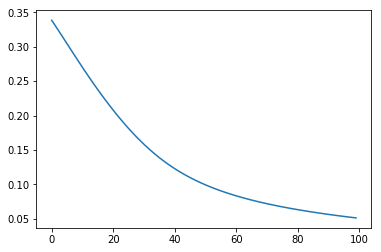

In [6]:
r = 2 
X_train_scaled, X_test_scaled, y_train, y_test = loadRdigits(r)
runNN(r)

ogrenme kumesinin uzunlugu:  402
test kumesinin uzunlugu:  135
X_train.shape (64, 402)
y_train.shape (3, 402)
b .shape:  (12, 1)   w .shape:  (12, 64)
b .shape:  (3, 1)   w .shape:  (3, 12)
delta_b[-1] .shape:  (3, 1)   delta_w[-1] .shape:  (3, 12)
delta_b[-k] .shape:  (12, 1)   delta_w[-k] .shape:  (12, 64)
Time:  3.423674616002245
					---Our Own Neural Network---
confusion_matrix:
 [[37  0  0]
 [ 5 18 36]
 [ 7  0 32]]
accuracy_score:  0.6444444444444445

Matrix Shape
b.shape:  (12, 1)  w.shape:  (12, 64)
b.shape:  (3, 1)  w.shape:  (3, 12)


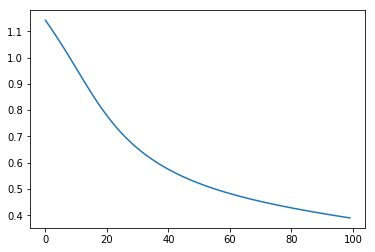

In [7]:
r = 3
X_train_scaled, X_test_scaled, y_train, y_test = loadRdigits(r)
runNN(r)

ogrenme kumesinin uzunlugu:  540
test kumesinin uzunlugu:  180
X_train.shape (64, 540)
y_train.shape (4, 540)
b .shape:  (12, 1)   w .shape:  (12, 64)
b .shape:  (4, 1)   w .shape:  (4, 12)
delta_b[-1] .shape:  (4, 1)   delta_w[-1] .shape:  (4, 12)
delta_b[-k] .shape:  (12, 1)   delta_w[-k] .shape:  (12, 64)
Time:  4.040801955998177
					---Our Own Neural Network---
confusion_matrix:
 [[44  3  3  2]
 [ 1 36  3  1]
 [ 6  1 31  5]
 [ 4  2  5 33]]
accuracy_score:  0.8

Matrix Shape
b.shape:  (12, 1)  w.shape:  (12, 64)
b.shape:  (4, 1)  w.shape:  (4, 12)


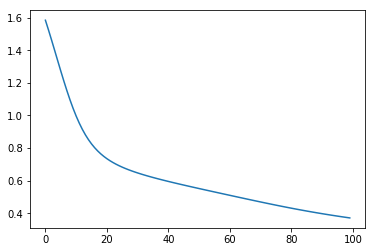

In [8]:
r = 4
X_train_scaled, X_test_scaled, y_train, y_test = loadRdigits(r)
runNN(r)

ogrenme kumesinin uzunlugu:  675
test kumesinin uzunlugu:  226
X_train.shape (64, 675)
y_train.shape (5, 675)
b .shape:  (12, 1)   w .shape:  (12, 64)
b .shape:  (5, 1)   w .shape:  (5, 12)
delta_b[-1] .shape:  (5, 1)   delta_w[-1] .shape:  (5, 12)
delta_b[-k] .shape:  (12, 1)   delta_w[-k] .shape:  (12, 64)
Time:  16.809887463998166
					---Our Own Neural Network---
confusion_matrix:
 [[43  0  0  0  0]
 [ 2 33  4  1  0]
 [ 0  2 52  5  0]
 [ 2  1  3 36  0]
 [ 0  3  1  0 38]]
accuracy_score:  0.8938053097345132

Matrix Shape
b.shape:  (12, 1)  w.shape:  (12, 64)
b.shape:  (5, 1)  w.shape:  (5, 12)


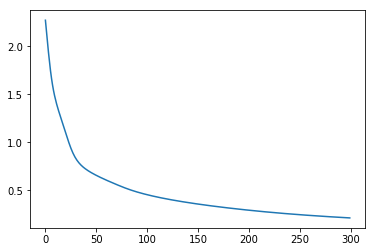

In [9]:
r = 5
X_train_scaled, X_test_scaled, y_train, y_test = loadRdigits(r)
runNN(r, alpha = 0.001, number_steps = 300)

ogrenme kumesinin uzunlugu:  812
test kumesinin uzunlugu:  271
X_train.shape (64, 812)
y_train.shape (6, 812)
b .shape:  (12, 1)   w .shape:  (12, 64)
b .shape:  (6, 1)   w .shape:  (6, 12)
delta_b[-1] .shape:  (6, 1)   delta_w[-1] .shape:  (6, 12)
delta_b[-k] .shape:  (12, 1)   delta_w[-k] .shape:  (12, 64)
Time:  6.4942146750108805
					---Our Own Neural Network---
confusion_matrix:
 [[47  0  0  0  4  2]
 [ 2 40  0  1  2  0]
 [ 1 12  0 16  3 10]
 [ 2  3  0 30  5  5]
 [ 4  7  0  0 31  1]
 [ 3  0  0  3  6 31]]
accuracy_score:  0.6605166051660517

Matrix Shape
b.shape:  (12, 1)  w.shape:  (12, 64)
b.shape:  (6, 1)  w.shape:  (6, 12)


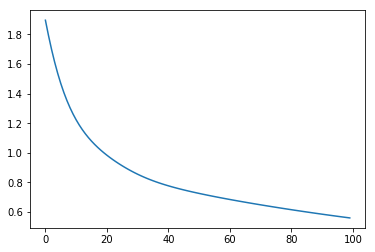

In [10]:
r = 6
X_train_scaled, X_test_scaled, y_train, y_test = loadRdigits(r)
runNN(r)

ogrenme kumesinin uzunlugu:  948
test kumesinin uzunlugu:  316
X_train.shape (64, 948)
y_train.shape (7, 948)
b .shape:  (12, 1)   w .shape:  (12, 64)
b .shape:  (7, 1)   w .shape:  (7, 12)
delta_b[-1] .shape:  (7, 1)   delta_w[-1] .shape:  (7, 12)
delta_b[-k] .shape:  (12, 1)   delta_w[-k] .shape:  (12, 64)
Time:  7.8451804729993455
					---Our Own Neural Network---
confusion_matrix:
 [[40  1  0  1  0  1  0]
 [ 8  3 13  2  0 14  1]
 [ 0  0 34  6  0  5  3]
 [ 1  3  8 32  0  5  1]
 [18  2  4  0  1  8  6]
 [ 3  0  3  1  0 47  0]
 [15  1  8  1  0  3 13]]
accuracy_score:  0.5379746835443038

Matrix Shape
b.shape:  (12, 1)  w.shape:  (12, 64)
b.shape:  (7, 1)  w.shape:  (7, 12)


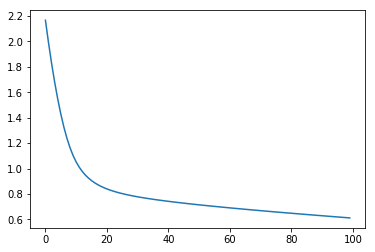

In [11]:
r = 7
X_train_scaled, X_test_scaled, y_train, y_test = loadRdigits(r)
runNN(r)

ogrenme kumesinin uzunlugu:  1082
test kumesinin uzunlugu:  361
X_train.shape (64, 1082)
y_train.shape (8, 1082)
b .shape:  (12, 1)   w .shape:  (12, 64)
b .shape:  (8, 1)   w .shape:  (8, 12)
delta_b[-1] .shape:  (8, 1)   delta_w[-1] .shape:  (8, 12)
delta_b[-k] .shape:  (12, 1)   delta_w[-k] .shape:  (12, 64)
Time:  8.6033596030029
					---Our Own Neural Network---
confusion_matrix:
 [[55  0  0  0  0  0  0  0]
 [ 1 16 13  0  1  2  0  1]
 [ 0  9 15  2  2  7  1  2]
 [ 2  5  7 21  0  2  4  3]
 [ 2  1  1  0 42  1  1  4]
 [ 4  0  3 12  1 13  3  1]
 [ 2  2  0  0  1  0 37  0]
 [ 0  1  3 15  9  0  1 30]]
accuracy_score:  0.6343490304709142

Matrix Shape
b.shape:  (12, 1)  w.shape:  (12, 64)
b.shape:  (8, 1)  w.shape:  (8, 12)


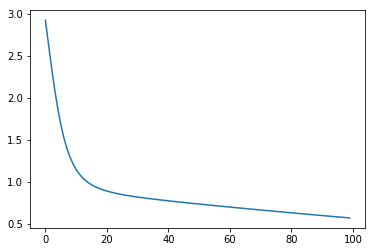

In [12]:
r = 8
X_train_scaled, X_test_scaled, y_train, y_test = loadRdigits(r)
runNN(r)

ogrenme kumesinin uzunlugu:  1212
test kumesinin uzunlugu:  405
X_train.shape (64, 1212)
y_train.shape (9, 1212)
b .shape:  (12, 1)   w .shape:  (12, 64)
b .shape:  (9, 1)   w .shape:  (9, 12)
delta_b[-1] .shape:  (9, 1)   delta_w[-1] .shape:  (9, 12)
delta_b[-k] .shape:  (12, 1)   delta_w[-k] .shape:  (12, 64)
Time:  93.34577839801204
					---Our Own Neural Network---
confusion_matrix:
 [[41  0  0  0  2  0  0  0  0]
 [ 0 31  7  0  0  0  1  0  0]
 [ 2  0 27  0  1  0  0  0  0]
 [ 0  0  3 38  0  0  0  0  2]
 [ 0  1  0  0 48  1  1  0  2]
 [ 0  0  0  1  0 43  0  0  0]
 [ 1  2  0  0  0  0 55  0  0]
 [ 0  0  0  0  2  0  0 45  0]
 [ 0  5  1  0  1  1  0  1 39]]
accuracy_score:  0.9061728395061729

Matrix Shape
b.shape:  (12, 1)  w.shape:  (12, 64)
b.shape:  (9, 1)  w.shape:  (9, 12)


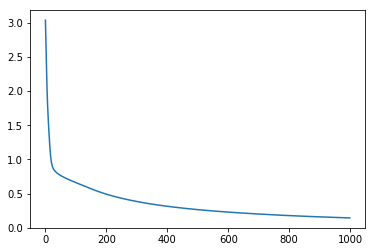

In [13]:
r = 9
X_train_scaled, X_test_scaled, y_train, y_test = loadRdigits(r)
runNN(r, alpha = 0.001, number_steps = 1000)